# Notebook traduit en français d'après celui du cours "Deep Learning" d'Alfredo Canziani de la New York University  : 
https://github.com/Atcold/pytorch-Deep-Learning/blob/master/08-seq_classification.ipynb

# Un exemple de "many-to-one" (plusieurs vers un) : classification de séquence

Expérience originale de [Hochreiter & Schmidhuber (1997)] (www.bioinf.jku.at/publications/older/2604.pdf).

L'objectif est de classer des séquences.
Les éléments et les cibles sont représentés localement (vecteurs d'entrée avec un seul bit non nul).
La séquence commence par un `B`, se termine par un `E` (le "symbole de déclenchement"). Elle est constituée de symboles choisis au hasard dans l'ensemble `{a, b, c, d}`, sauf pour deux éléments aux positions `t1` et `t2` qui sont soit `X` soit `Y`.
Dans le cas de `DifficultyLevel.HARD`, la longueur de la séquence est choisie au hasard entre `100` et `110`, `t1` est choisi au hasard entre `10` et `20`, et `t2` est choisi au hasard entre `50` et `60`.
Il existe 4 classes de séquences `Q`, `R`, `S` et `U`, qui dépendent de l'ordre temporel de `X` et `Y`.

Les règles sont les suivantes :

```
X, X -> Q,
X, Y -> R,
Y, X -> S,
Y, Y -> U.
```

## 1. Exploration du jeu de données

In [1]:
from res.sequential_tasks import TemporalOrderExp6aSequence as QRSU

In [4]:
# Création d'un générateur de données
example_generator = QRSU.get_predefined_generator(
    difficulty_level=QRSU.DifficultyLevel.EASY,
    batch_size=32,
)

example_batch = example_generator[1]
print(f'Le type généré est un {type(example_batch)} de longueur {len(example_batch)}.')
print(f'Le premier élément du tuple est le batch de séquences de la forme {example_batch[0].shape}.')
print(f'Le premier élément du batch de séquences est:\n {example_batch[0][0, :, :]}')
print(f'Le deuxième élément du tuple est le batch correspondant des labels de classe de la forme {example_batch[1].shape}.')
print(f'Le premier élément du batch d étiquettes de classe est:\n {example_batch[1][0, :]}')

Le type généré est un <class 'tuple'> de longueur 2.
Le premier élément du tuple est le batch de séquences de la forme (32, 9, 8).
Le premier élément du batch de séquences est:
 [[0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 1 0]
 [0 0 0 1 0 0 0 0]
 [1 0 0 0 0 0 0 0]
 [0 0 0 0 1 0 0 0]
 [1 0 0 0 0 0 0 0]
 [0 0 0 0 1 0 0 0]
 [0 0 0 1 0 0 0 0]
 [0 0 0 0 0 0 0 1]]
Le deuxième élément du tuple est le batch correspondant des labels de classe de la forme (32, 4).
Le premier élément du batch d étiquettes de classe est:
 [1. 0. 0. 0.]


In [5]:
# Décodage de la première séquence
sequence_decoded = example_generator.decode_x(example_batch[0][0, :, :])
print(f'La séquence est: {sequence_decoded}')

# Décodage du label de la classe de la première séquence
class_label_decoded = example_generator.decode_y(example_batch[1][0])
print(f'Le label de la classe est: {class_label_decoded}')

La séquence est: BbXcXcbE
Le label de la classe est: Q


## 2. Définir le modèle

In [6]:
import torch
import torch.nn as nn

# Fixation de la graine pour reproduire les résultats 
torch.manual_seed(1)

class SimpleRNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        # Ceci appelle juste le constructeur de la classe de base
        super().__init__()
        # Couches de réseau neuronal assignés comme attributs d'une sous-classe de module
        # ont leurs paramètres enregistrés automatiquement pour l'entraînement.
        self.rnn = torch.nn.RNN(input_size, hidden_size, nonlinearity='relu', batch_first=True)
        self.linear = torch.nn.Linear(hidden_size, output_size)

    def forward(self, x):
        # Le RNN retourne aussi son état caché mais nous ne l'utilisons pas.
        # Alors que le RNN peut également prendre un état caché en entrée, il
        # passe un état caché initialisé avec des zéros par défaut.
        h = self.rnn(x)[0]
        x = self.linear(h)
        return x

class SimpleLSTM(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super().__init__()
        self.lstm = torch.nn.LSTM(input_size, hidden_size, batch_first=True)
        self.linear = torch.nn.Linear(hidden_size, output_size)

    def forward(self, x):
        h = self.lstm(x)[0]
        x = self.linear(h)
        return x
    
    def get_states_across_time(self, x):
        h_c = None
        h_list, c_list = list(), list()
        with torch.no_grad():
            for t in range(x.size(1)):
                h_c = self.lstm(x[:, [t], :], h_c)[1]
                h_list.append(h_c[0])
                c_list.append(h_c[1])
            h = torch.cat(h_list)
            c = torch.cat(c_list)
        return h, c

## 3. Définir la boucle d'entraînement

In [7]:
def train(model, train_data_gen, criterion, optimizer, device):
    # Mettre le modèle en mode entraînement. Cela permettra d'activer des couches qui,
    # autrement, se comporteraient différemment pendant l'évaluation, comme le dropout
    model.train()

    # Stocker le nombre de séquences qui ont été correctement classées
    num_correct = 0


    # Itération sur chaque batch de séquences. Notez que la longueur d'un générateur de données 
    # est définie comme le nombre de batchs nécessaires pour produire un total d'environ 1000 séquences,
    # compte tenu de la taille du batch.
    for batch_idx in range(len(train_data_gen)):

        # Demander un batch de séquences et de labels de classe, les convertir en tenseurs
        # du bon type, puis les envoyer à l'appareil approprié.
        data, target = train_data_gen[batch_idx]
        data, target = torch.from_numpy(data).float().to(device), torch.from_numpy(target).long().to(device)

        # Effectuer la propagation avant du modèle
        output = model(data)  # Etape ①

        # Choisir uniquement la sortie correspondant au dernier élément de la séquence (l'entrée est pré-remplie)
        output = output[:, -1, :]

        # Calculer la valeur de la perte pour ce batch. Pour les fonctions de perte comme CrossEntropyLoss,
        # le deuxième argument est en fait censé être un tenseur d'indices de classe plutôt que
        # des labels de classe one-hot. Une approche consiste à tirer parti de l'encodage one-hot
        # de la cible et appeler argmax le long de sa deuxième dimension pour créer un tenseur de forme
        # (batch_size) contenant l'index du label de classe pour chaque séquence.
        target = target.argmax(dim=1)

        loss = criterion(output, target)  # Etape ②

        # Effacer les tampons des gradients des paramètres optimisés.
        # Sinon, les gradients du batch précédent s'accumuleraient.
        optimizer.zero_grad()  # Etape ③

        loss.backward()  # Etape ④

        optimizer.step()  # Etape ⑤

        y_pred = output.argmax(dim=1)
        num_correct += (y_pred == target).sum().item()

    return num_correct, loss.item()

## 4. Définir la boucle de test

In [8]:
def test(model, test_data_gen, criterion, device):
    # Mettre le modèle en mode évaluation. Cela permettra de désactiver des couches qui, 
    # autrement, se comporteraient différemment pendant l'entraînement, comme par exemple le dropout.
    model.eval()

    # Stocker le nombre de séquences qui ont été correctement classées
    num_correct = 0

    
    # Un gestionnaire de contexte est utilisé pour désactiver les calculs de gradient pendant l'inférence
    # afin de réduire l'utilisation de la mémoire. En effet nous n'avons généralement pas besoin des gradients à ce stade.
    with torch.no_grad():
        for batch_idx in range(len(test_data_gen)):
            data, target = test_data_gen[batch_idx]
            data, target = torch.from_numpy(data).float().to(device), torch.from_numpy(target).long().to(device)

            output = model(data)
            # Choisir uniquement la sortie correspondant au dernier élément de la séquence (l'entrée est pré-remplie)
            output = output[:, -1, :]

            target = target.argmax(dim=1)
            loss = criterion(output, target)

            y_pred = output.argmax(dim=1)
            num_correct += (y_pred == target).sum().item()

    return num_correct, loss.item()

## 5. Tout mettre ensemble

In [10]:
import matplotlib.pyplot as plt
from res.plot_lib import set_default, plot_state, print_colourbar

In [11]:
set_default()

In [12]:
def train_and_test(model, train_data_gen, test_data_gen, criterion, optimizer, max_epochs, verbose=True):
    # Déterminer automatiquement le périphérique que PyTorch doit utiliser pour le calcul
    device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

    # Suivre la valeur de la fonction de perte et la précision du modèle à travers les époques
    history_train = {'loss': [], 'acc': []}
    history_test = {'loss': [], 'acc': []}

    for epoch in range(max_epochs):
        # Fais tourner la boucle d'entraînement et calcule la précision.
        # Rappelez-vous que la longueur d'un générateur de données est le nombre de batch,
        # donc nous le multiplions par la taille du batch pour récupérer le nombre total de séquences.
        num_correct, loss = train(model, train_data_gen, criterion, optimizer, device)
        accuracy = float(num_correct) / (len(train_data_gen) * train_data_gen.batch_size) * 100
        history_train['loss'].append(loss)
        history_train['acc'].append(accuracy)

        # Même chose pour la boucle de test
        num_correct, loss = test(model, test_data_gen, criterion, device)
        accuracy = float(num_correct) / (len(test_data_gen) * test_data_gen.batch_size) * 100
        history_test['loss'].append(loss)
        history_test['acc'].append(accuracy)

        if verbose or epoch + 1 == max_epochs:
            print(f'[Epoch {epoch + 1}/{max_epochs}]'
                  f" loss: {history_train['loss'][-1]:.4f}, acc: {history_train['acc'][-1]:2.2f}%"
                  f" - test_loss: {history_test['loss'][-1]:.4f}, test_acc: {history_test['acc'][-1]:2.2f}%")

    # Générer des diagrammes de diagnostic pour la perte et la précision
    fig, axes = plt.subplots(ncols=2, figsize=(9, 4.5))
    for ax, metric in zip(axes, ['loss', 'acc']):
        ax.plot(history_train[metric])
        ax.plot(history_test[metric])
        ax.set_xlabel('epoch', fontsize=12)
        ax.set_ylabel(metric, fontsize=12)
        ax.legend(['Train', 'Test'], loc='best')
    plt.show()

    return model

## 5. Simple RNN: 10 époques

[Epoch 1/10] loss: 1.4213, acc: 24.29% - test_loss: 1.3710, test_acc: 31.35%
[Epoch 2/10] loss: 1.3603, acc: 30.75% - test_loss: 1.3846, test_acc: 37.50%
[Epoch 3/10] loss: 1.3673, acc: 40.22% - test_loss: 1.3910, test_acc: 40.12%
[Epoch 4/10] loss: 1.3636, acc: 39.82% - test_loss: 1.3435, test_acc: 43.85%
[Epoch 5/10] loss: 1.2752, acc: 44.35% - test_loss: 1.3282, test_acc: 36.59%
[Epoch 6/10] loss: 1.2631, acc: 40.22% - test_loss: 1.2412, test_acc: 41.03%
[Epoch 7/10] loss: 1.2340, acc: 44.35% - test_loss: 1.2670, test_acc: 47.58%
[Epoch 8/10] loss: 1.1193, acc: 50.40% - test_loss: 1.2446, test_acc: 48.69%
[Epoch 9/10] loss: 1.2194, acc: 48.89% - test_loss: 1.1098, test_acc: 50.81%
[Epoch 10/10] loss: 1.0805, acc: 48.69% - test_loss: 1.0649, test_acc: 52.72%


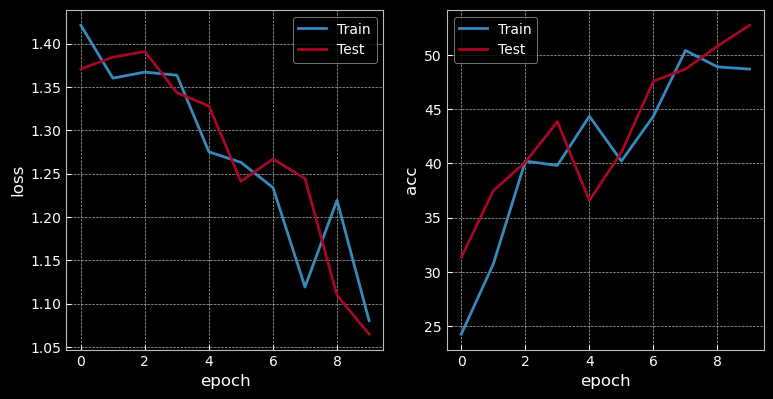

In [13]:
# Configurer les générateurs de données
difficulty     = QRSU.DifficultyLevel.EASY
batch_size     = 32
train_data_gen = QRSU.get_predefined_generator(difficulty, batch_size)
test_data_gen  = QRSU.get_predefined_generator(difficulty, batch_size)

# Configurer le RNN et les paramètres d'entraînement
input_size  = train_data_gen.n_symbols
hidden_size = 4
output_size = train_data_gen.n_classes
model       = SimpleRNN(input_size, hidden_size, output_size)
criterion   = torch.nn.CrossEntropyLoss()
optimizer   = torch.optim.RMSprop(model.parameters(), lr=0.001)
max_epochs  = 10

# Entraîner le modèle
model = train_and_test(model, train_data_gen, test_data_gen, criterion, optimizer, max_epochs)

In [14]:
for parameter_group in list(model.parameters()):
    print(parameter_group.size())

torch.Size([4, 8])
torch.Size([4, 4])
torch.Size([4])
torch.Size([4])
torch.Size([4, 4])
torch.Size([4])


## 5. Simple LSTM: 10 époques

[Epoch 1/10] loss: 1.3307, acc: 32.66% - test_loss: 1.4515, test_acc: 29.03%
[Epoch 2/10] loss: 1.3932, acc: 28.02% - test_loss: 1.3997, test_acc: 26.01%
[Epoch 3/10] loss: 1.3456, acc: 37.40% - test_loss: 1.3411, test_acc: 50.71%
[Epoch 4/10] loss: 1.2591, acc: 49.19% - test_loss: 1.2757, test_acc: 53.93%
[Epoch 5/10] loss: 1.1803, acc: 48.89% - test_loss: 1.1728, test_acc: 50.50%
[Epoch 6/10] loss: 1.1296, acc: 58.77% - test_loss: 1.0896, test_acc: 71.98%
[Epoch 7/10] loss: 1.0777, acc: 77.72% - test_loss: 1.0764, test_acc: 80.14%
[Epoch 8/10] loss: 1.0456, acc: 82.56% - test_loss: 1.0916, test_acc: 95.06%
[Epoch 9/10] loss: 0.9874, acc: 96.27% - test_loss: 0.9321, test_acc: 99.40%
[Epoch 10/10] loss: 0.8819, acc: 97.98% - test_loss: 0.8538, test_acc: 99.90%


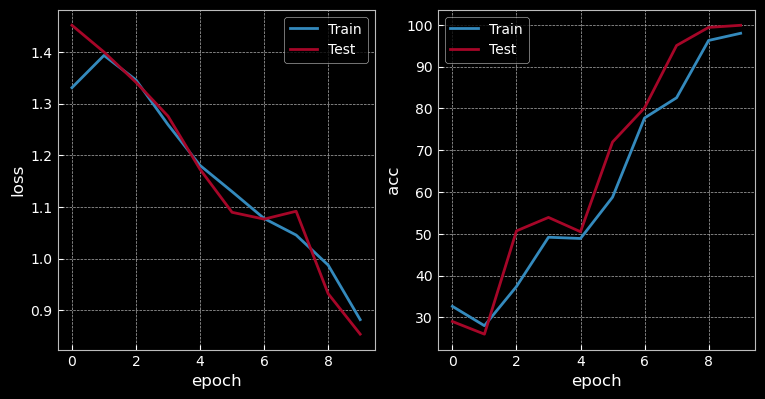

In [15]:
# Configurer les générateurs de données
difficulty     = QRSU.DifficultyLevel.EASY
batch_size     = 32
train_data_gen = QRSU.get_predefined_generator(difficulty, batch_size)
test_data_gen  = QRSU.get_predefined_generator(difficulty, batch_size)

# Configurer le LSTM et les paramètres d'entraînement
input_size  = train_data_gen.n_symbols
hidden_size = 4
output_size = train_data_gen.n_classes
model       = SimpleLSTM(input_size, hidden_size, output_size)
criterion   = torch.nn.CrossEntropyLoss()
optimizer   = torch.optim.RMSprop(model.parameters(), lr=0.001)
max_epochs  = 10

# Entraîner le modèle
model = train_and_test(model, train_data_gen, test_data_gen, criterion, optimizer, max_epochs)

In [16]:
for parameter_group in list(model.parameters()):
    print(parameter_group.size())

torch.Size([16, 8])
torch.Size([16, 4])
torch.Size([16])
torch.Size([16])
torch.Size([4, 4])
torch.Size([4])


## 6. RNN: 100 époques

[Epoch 100/100] loss: 0.0077, acc: 100.00% - test_loss: 0.0070, test_acc: 100.00%


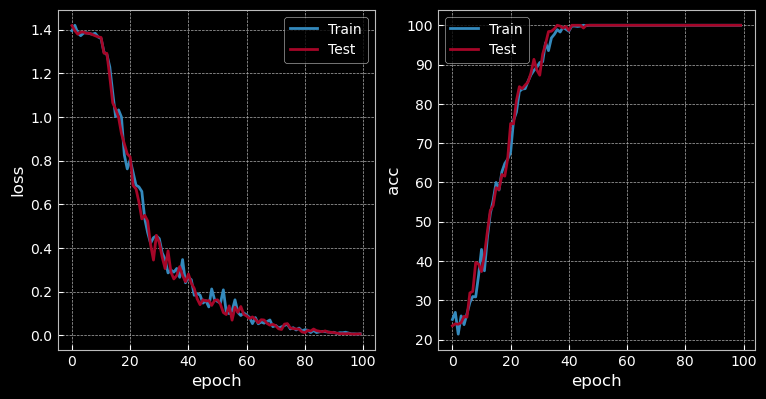

In [17]:
# Configurer les générateurs de données
difficulty     = QRSU.DifficultyLevel.EASY
batch_size     = 32
train_data_gen = QRSU.get_predefined_generator(difficulty, batch_size)
test_data_gen  = QRSU.get_predefined_generator(difficulty, batch_size)

# Configurer le RNN et les paramètres d'entraînement
input_size  = train_data_gen.n_symbols
hidden_size = 4
output_size = train_data_gen.n_classes
model       = SimpleRNN(input_size, hidden_size, output_size)
criterion   = torch.nn.CrossEntropyLoss()
optimizer   = torch.optim.RMSprop(model.parameters(), lr=0.001)
max_epochs  = 100

# Entraîner le modèle
model = train_and_test(model, train_data_gen, test_data_gen, criterion, optimizer, max_epochs, verbose=False)

## LSTM: 100 époques

[Epoch 100/100] loss: 0.0017, acc: 100.00% - test_loss: 0.0017, test_acc: 100.00%


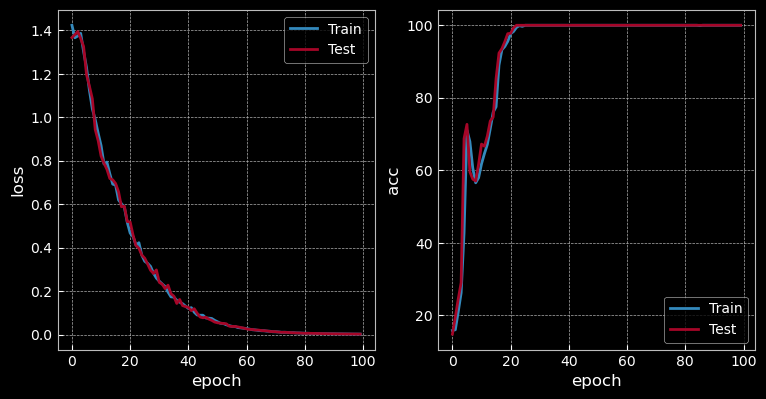

In [18]:
# Configurer les générateurs de données
difficulty     = QRSU.DifficultyLevel.EASY
batch_size     = 32
train_data_gen = QRSU.get_predefined_generator(difficulty, batch_size)
test_data_gen  = QRSU.get_predefined_generator(difficulty, batch_size)

# Configurer le LSTM et les paramètres d'entraînement
input_size  = train_data_gen.n_symbols
hidden_size = 4
output_size = train_data_gen.n_classes
model       = SimpleLSTM(input_size, hidden_size, output_size)
criterion   = torch.nn.CrossEntropyLoss()
optimizer   = torch.optim.RMSprop(model.parameters(), lr=0.001)
max_epochs  = 100

# Entraîner le modèle
model = train_and_test(model, train_data_gen, test_data_gen, criterion, optimizer, max_epochs, verbose=False)

## 7. Evalutation du modèle

In [19]:
import collections
import random

def evaluate_model(model, difficulty, seed=9001, verbose=False):
    # Définir un dictionnaire qui associe les indices de classe aux labels
    class_idx_to_label = {0: 'Q', 1: 'R', 2: 'S', 3: 'U'}

    # Créer un nouveau générateur de données
    data_generator = QRSU.get_predefined_generator(difficulty, seed=seed)

    # Suivre le nombre de fois qu'une classe apparaît
    count_classes = collections.Counter()

    # Garder les séquences correctement classées et mal classées, et leurs labels réels et prédit,
    # pour les informations de diagnostic.
    correct = []
    incorrect = []

    device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

    model.eval()

    with torch.no_grad():
        for batch_idx in range(len(data_generator)):
            data, target = test_data_gen[batch_idx]
            data, target = torch.from_numpy(data).float().to(device), torch.from_numpy(target).long().to(device)

            data_decoded = data_generator.decode_x_batch(data.numpy())
            target_decoded = data_generator.decode_y_batch(target.numpy())

            output = model(data)
            sequence_end = torch.tensor([len(sequence) for sequence in data_decoded]) - 1
            output = output[torch.arange(data.shape[0]).long(), sequence_end, :]

            target = target.argmax(dim=1)
            y_pred = output.argmax(dim=1)
            y_pred_decoded = [class_idx_to_label[y.item()] for y in y_pred]

            count_classes.update(target_decoded)
            for i, (truth, prediction) in enumerate(zip(target_decoded, y_pred_decoded)):
                if truth == prediction:
                    correct.append((data_decoded[i], truth, prediction))
                else:
                    incorrect.append((data_decoded[i], truth, prediction))

    num_sequences = sum(count_classes.values())
    accuracy = float(len(correct)) / num_sequences * 100
    print(f'La précision du modèle est mesurée pour être {accuracy:.2f}%.\n')

    # Rapporter la précision par classe
    for label in sorted(count_classes):
        num_correct = sum(1 for _, truth, _ in correct if truth == label)
        print(f'{label}: {num_correct} / {count_classes[label]} correct')

    # Rapporter quelques séquences aléatoires pour examen
    print('\nQuelques exemples de séquences:')
    for i in range(10):
        sequence, truth, prediction = correct[random.randrange(0, 10)]
        print(f'{sequence} -> {truth} a été labellisé {prediction}')

    # Signaler les séquences mal classées pour l'enquête
    if incorrect and verbose:
        print('\nLes séquences suivantes ont été mal classées :')
        for sequence, truth, prediction in incorrect:
            print(f'{sequence} -> {truth} a été labellisé {prediction}')
    else:
        print('\nIl n y a pas eu de séquences mal classées.')

In [20]:
evaluate_model(model, difficulty)

La précision du modèle est mesurée pour être 85.08%.

Q: 193 / 258 correct
R: 249 / 249 correct
S: 149 / 232 correct
U: 253 / 253 correct

Quelques exemples de séquences:
BXacbYdE -> R a été labellisé R
BbXcXbcE -> Q a été labellisé Q
BdYdXbbE -> S a été labellisé S
BcYacYbE -> U a été labellisé U
BXacbYdE -> R a été labellisé R
BYbdYabE -> U a été labellisé U
BXacbYdE -> R a été labellisé R
BbXaXdE -> Q a été labellisé Q
BYbdYabE -> U a été labellisé U
BYbdYabE -> U a été labellisé U

Il n y a pas eu de séquences mal classées.


## 8. Visualiser le LSTM
Régler la difficulté sur `MODERATE` et la `hidden_size` sur 12.

[Epoch 100/100] loss: 0.0144, acc: 100.00% - test_loss: 0.0163, test_acc: 99.80%


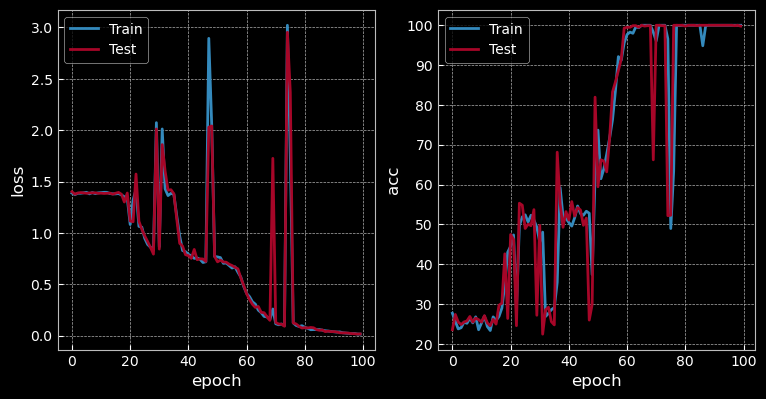

In [21]:
# Pour la reproductibilité
torch.manual_seed(1)

# Configurer les générateurs de données
difficulty     = QRSU.DifficultyLevel.MODERATE
batch_size     = 32
train_data_gen = QRSU.get_predefined_generator(difficulty, batch_size)
test_data_gen  = QRSU.get_predefined_generator(difficulty, batch_size)

# Configurer le RNN et les paramètres d'entraînement
input_size  = train_data_gen.n_symbols
hidden_size = 10
output_size = train_data_gen.n_classes
model       = SimpleLSTM(input_size, hidden_size, output_size)
criterion   = torch.nn.CrossEntropyLoss()
optimizer   = torch.optim.RMSprop(model.parameters(), lr=0.001)
max_epochs  = 100

# Entraîner le modèle
model = train_and_test(model, train_data_gen, test_data_gen, criterion, optimizer, max_epochs, verbose=False)

In [22]:
# Obtenir l'état caché (H) et la cellule (C) étant donné une entrée de batch (X)
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
model.eval()
with torch.no_grad():
    data = test_data_gen[0][0]
    X = torch.from_numpy(data).float().to(device)
    H_t, C_t = model.get_states_across_time(X)

In [23]:
print("La gamme de couleurs est la suivante :")
print_colourbar()

La gamme de couleurs est la suivante :


In [24]:
plot_state(X, C_t, b=9, decoder=test_data_gen.decode_x)  # 3, 6, 9

In [25]:
plot_state(X, H_t, b=9, decoder=test_data_gen.decode_x)